continuing with the age old dog vs cat classifier now using the concept of transfer learning by implementing an already popular model in open source communities

In [2]:
import os
import pickle

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3

import matplotlib.pyplot as plt

from io import BytesIO
from ipywidgets import widgets

In [3]:
pre_trained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'  
)

for layer in pre_trained_model.layers:
    layer.trainable = False

I0000 00:00:1753174055.437540   18369 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5220 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
pre_trained_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


adding dense layers for neural network with dropout

In [6]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense  (1, activation='sigmoid')(x)

model = tf.keras.Model(pre_trained_model.input, x)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 74, 74,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 72, 72,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 72, 72,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 72, 72,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 35, 35,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 35, 35,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 33, 33,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 33, 33,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 33, 33,    │          0 │ batch_normalizat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [7]:
TRAIN_DIR = 'train'
VAL_DIR   = 'test'

train_dogs_dir   = os.path.join(TRAIN_DIR, 'dogs')
train_cats_dir   = os.path.join(TRAIN_DIR, 'cats')
validate_dogs_dir = os.path.join(VAL_DIR, 'dogs')
validate_cats_dir = os.path.join(VAL_DIR, 'cats')

In [8]:
print(f"total training dogs images: {len(os.listdir(train_dogs_dir))}")
print(f"total training cats images: {len(os.listdir(train_cats_dir))}")
print(f"total validation dogs images: {len(os.listdir(validate_dogs_dir))}")
print(f"total validation cats images: {len(os.listdir(validate_cats_dir))}")

total training dogs images: 10000
total training cats images: 10000
total validation dogs images: 2500
total validation cats images: 2500


In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


starting preprocessing 

In [10]:
def preprocess(image, label):
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image, label

train_dataset_scaled = train_dataset.map(preprocess)
validation_dataset_scaled = validation_dataset.map(preprocess)

In [11]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = (train_dataset_scaled
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       )

validation_dataset_final = (validation_dataset_scaled
                            .cache()
                            .prefetch(PREFETCH_BUFFER_SIZE)
                            )

preparing the model for training

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.4),
    tf.keras.layers.RandomTranslation(0.2,0.2),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomZoom(0.2),
    ])

In [13]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = model(x)

model_with_aug = tf.keras.Model(inputs, x)

In [14]:
model_with_aug.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [15]:
history = model_with_aug.fit(
    train_dataset_final,
    validation_data = validation_dataset_final,
    epochs = 20,
    verbose = 2)

Epoch 1/20


I0000 00:00:1753174143.084376   18468 cuda_dnn.cc:529] Loaded cuDNN version 91002


1000/1000 - 43s - 43ms/step - accuracy: 0.7503 - loss: 0.5022 - val_accuracy: 0.9516 - val_loss: 0.1314
Epoch 2/20
1000/1000 - 30s - 30ms/step - accuracy: 0.7901 - loss: 0.4413 - val_accuracy: 0.9588 - val_loss: 0.1068
Epoch 3/20
1000/1000 - 30s - 30ms/step - accuracy: 0.7948 - loss: 0.4285 - val_accuracy: 0.9582 - val_loss: 0.1190
Epoch 4/20
1000/1000 - 30s - 30ms/step - accuracy: 0.8033 - loss: 0.4149 - val_accuracy: 0.9568 - val_loss: 0.1325
Epoch 5/20
1000/1000 - 31s - 31ms/step - accuracy: 0.8021 - loss: 0.4134 - val_accuracy: 0.9592 - val_loss: 0.1095
Epoch 6/20
1000/1000 - 32s - 32ms/step - accuracy: 0.8137 - loss: 0.3997 - val_accuracy: 0.9508 - val_loss: 0.1557
Epoch 7/20
1000/1000 - 31s - 31ms/step - accuracy: 0.8177 - loss: 0.3922 - val_accuracy: 0.9616 - val_loss: 0.1141
Epoch 8/20
1000/1000 - 29s - 29ms/step - accuracy: 0.8180 - loss: 0.3958 - val_accuracy: 0.9600 - val_loss: 0.1157
Epoch 9/20
1000/1000 - 29s - 29ms/step - accuracy: 0.8180 - loss: 0.3889 - val_accuracy: 0.

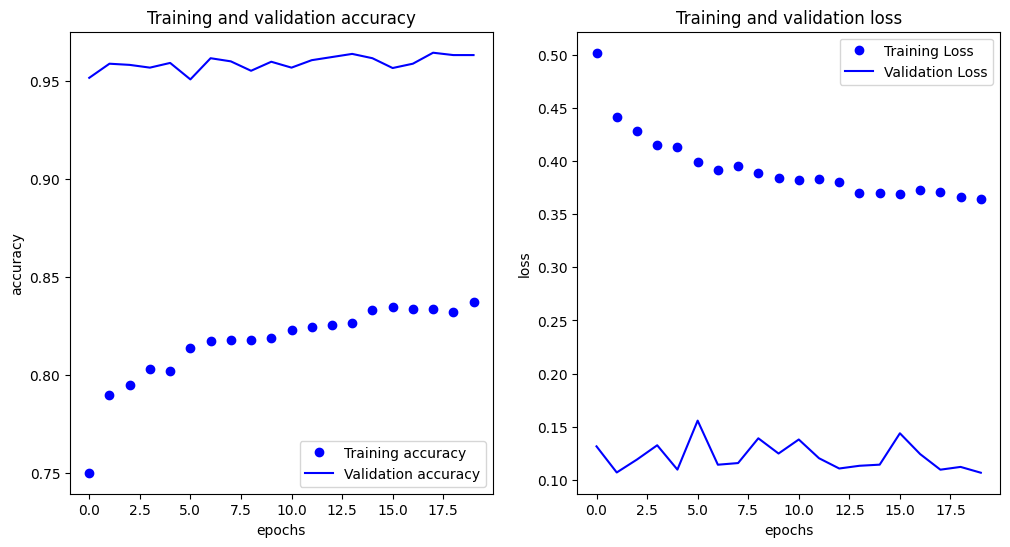

In [16]:
def plot_loss_acc(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

great results overall , much better than custom built models

In [17]:
rescale_layer = tf.keras.layers.Rescaling(1./255)

In [18]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = rescale_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    
    items = change.new
    for item in items: 
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)

uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [19]:
with open('model.pkl','wb') as f:
    pickle.dump(history.history , f)